<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/AlternativeModels_Lukas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import datetime
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from google.colab import drive

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

import lightgbm as lgb
import xgboost as xgb

from seaborn import heatmap
#!pip install earthpy
#import earthpy as et
#import earthpy.spatial as es
#import earthpy.plot as ep


In [3]:
drive.mount('/content/drive')
data = np.load('/content/drive/MyDrive/Colab Notebooks/Data/train.npz')
test_data = np.load('/content/drive/MyDrive/Colab Notebooks/Data/public_test.npz')


Mounted at /content/drive


In [5]:
## TRAIN data
# separate bands and labels:
train_data_raw = data['bands']
labels_raw = data['lulc']

In [6]:
## TEST data
# extract data:
X_test_raw_shape = test_data['bands']
X_test_raw_shape.shape

(12, 500, 500, 6)

In [7]:
# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])
classes_without_empty_labels=np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Artificial Surface', 'Bareland'])


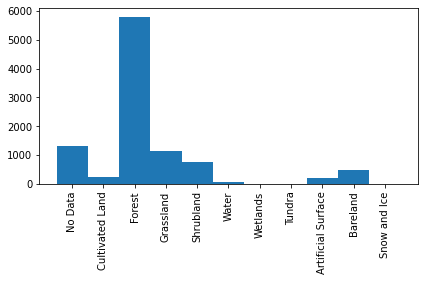

In [8]:
# Class distribution:
plt.hist(labels_raw, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [9]:
train_data_raw.shape

(10000, 12, 33, 33, 6)

# Preprocessing:

Do not use data points with "no data" as label:

In [10]:
# Get indices where label = no data:
no_data_indices = labels_raw != 0

# Exclude them from training set:
train_data = train_data_raw[no_data_indices]
labels = labels_raw[no_data_indices]

Extract Center Points from 33x33 Patches

In [11]:
# extract middle pixel data for each patch:
train_data_center_points_month_and_channel = train_data[:,:,16,16,:]
train_data_center_points_month_and_channel.shape

num_data_points = 8692

In [12]:
# reshape training data:
# results in [channel1_jan, channel2_jan, ..., channel6_jan, channel1_feb, ...]
train_data_center_points = train_data_center_points_month_and_channel.reshape((num_data_points,72))
train_data_center_points.shape

#print(train_data[42,:,16,16,:])
#print(train_data_center_points[42,])

# Varify that value for 42nd patch in November for fourth band for central Pixel is the same in raw train data and reshaped train data
print(train_data[42,10,16,16,3])
print(train_data_center_points[42,10*6+3])

0.1736
0.1736


In [13]:
# Split data into train and val set:
X_train, X_val, y_train, y_val = train_test_split(train_data_center_points, labels, 
                                                    test_size=0.25, stratify = labels, random_state=42)

In [16]:
## reshape test data:
# move months to third axis:
print(X_test_raw_shape.shape)

X_test_raw_axis_order_changed = np.moveaxis(X_test_raw_shape,0,-2)
print(X_test_raw_axis_order_changed.shape)

# combine pixel x and y axes:
X_test_raw_axis_combined= X_test_raw_axis_order_changed.reshape((250000, 6, 12))
print(X_test_raw_axis_combined.shape)

# combine channel and month axes:
X_test= X_test_raw_axis_combined.reshape((250000, 72))
print(X_test.shape)


# Varify that value in November for fourth band for Pixel(X=100, Y=42) is the same in raw test data and reshaped test data
print(X_test_raw_shape[10,100,42,3])
print(X_test[100*500+42,10*6+3])

(12, 500, 500, 6)
(500, 500, 12, 6)
(250000, 6, 12)
(250000, 72)
1.0212
1.0212


Extracting average/median values of surrounding pixels:


In [18]:
# extract neighbor pixels for each patch:
train_data_central_pixels_only = train_data[:,:,16:19,16:19,:]
train_data_central_pixels_only.shape

(8692, 12, 3, 3, 6)

In [19]:
# compute mean along side pixel axes (3rd and 4th axis)
pixel_means = np.mean(train_data_central_pixels_only, axis=(2,3))


# Check if everything is working as intended:
print(train_data_central_pixels_only[42,10,:,:,4].mean())
print(pixel_means[42,10,4])

0.07723334
0.07723333


In [37]:
# create list of numpy array with surrounding pixels:
pixel_sets = []
# close pixels (distances 1 - 2)
for i in range(1,2):
  pixel_sets.append(train_data[:,:,17-i:17+i,17-i:17+i,:])
# further fixels (distances 5, 15):
#for i in range(5,20,10):
#  pixel_sets.append(train_data[:,:,17-i:17+i,17-i:17+i,:])


# distances 1 - 17:
#for i in range(1,18):
#  pixel_sets.append(train_data[:,:,17-i:17+i,17-i:17+i,:])

In [38]:
# compute means for each of the sets:
pixel_sets_mean = [np.mean(pixel_set, axis=(2,3)) for pixel_set in pixel_sets]

In [39]:
# combine month and channel data by reshaping: (10000,72)
pixel_sets_mean_reshaped = [np.reshape(pixel_set,(num_data_points,72)) for pixel_set in pixel_sets_mean]

In [40]:
# combine sets:
sets_combined = np.concatenate(pixel_sets_mean_reshaped, axis=1)
print(sets_combined.shape)

# combine sets with central pixels:
all_combined = np.concatenate((sets_combined, train_data_center_points), axis=1)
print(all_combined.shape)

(8692, 72)
(8692, 144)


In [41]:
# Split data into train and val set:
X_train_v2, X_val_v2, y_train_v2, y_val_v2 = train_test_split(all_combined, labels, 
                                                    test_size=0.25, stratify = labels, random_state=42)
print(X_train_v2.shape)
print(y_train_v2.shape)

(6519, 144)
(6519,)


Split up into data for each month:


In [ ]:
X_train_per_month = [train_data_center_points_month_and_channel[:,month,:] for month in range(12)]

# kNearestNeighbors Model


In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
# Predict the labels of test data

knn_pred = knn.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, knn_pred)*100}")

print(classification_report(y_val, knn_pred))

Accuracy: 75.37965945697192
              precision    recall  f1-score   support

           1       0.53      0.38      0.45        60
           2       0.79      0.98      0.87      1449
           3       0.63      0.30      0.41       281
           4       0.48      0.21      0.30       192
           5       1.00      0.33      0.50        15
           8       1.00      0.02      0.04        54
           9       0.63      0.55      0.59       122

    accuracy                           0.75      2173
   macro avg       0.72      0.40      0.45      2173
weighted avg       0.73      0.75      0.71      2173



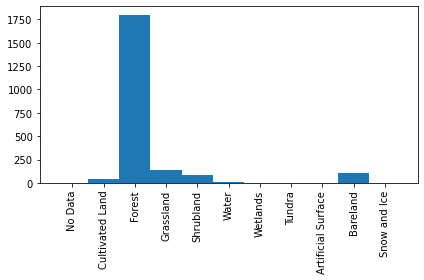

In [ ]:
plt.hist(knn_pred, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

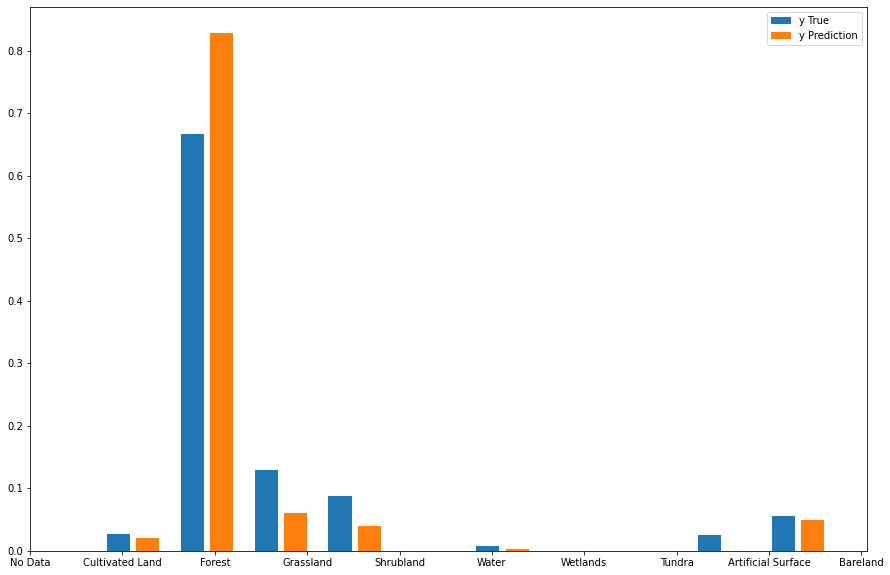

In [ ]:
true = y_val
pred = knn_pred

plt.figure(figsize=[15, 10])
plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.hist(pred, color = 'y', width = 0.25, histtype='bar')
classes = ['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland']
plt.legend(['y True', 'y Prediction'])

plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

GridSearch optimal k parameter:

In [ ]:
grid_search_params = {
    'n_neighbors': [3,5,10,15,20],
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_search_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

gs_results = gs.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   45.2s finished


In [ ]:
# Best accuracy score
print('Best accuracy: ' + str(gs_results.best_score_))

# Best paramters
print('Best parameters: '+str(gs_results.best_params_))


Best accuracy: 0.7718975302960577
Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
# Apply best model and get predictions:
best_knn_predictions = gs_results.best_estimator_.predict(X_val)

# Print accuracy:
print(f"Accuracy: {accuracy_score(y_val, best_knn_predictions)*100}")

Accuracy: 78.27887712839392


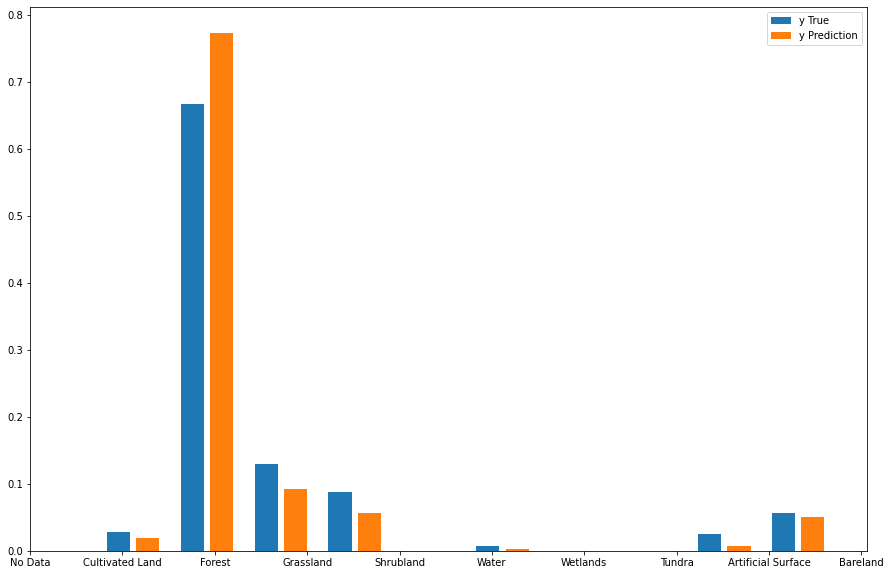

In [ ]:
true = y_val
pred = best_knn_predictions

plt.figure(figsize=[15, 10])
plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.hist(pred, color = 'y', width = 0.25, histtype='bar')
classes = ['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland']
plt.legend(['y True', 'y Prediction'])

plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

# Support Vector Machines


In [ ]:
svm = SVC(C=1.0, kernel='linear', degree=6, cache_size=1024)

# Fit Data
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=1024, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=6, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Predict labels for test data
svm_pred = svm.predict(X_val)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, svm_pred)*100}")
print(classification_report(y_val, svm_pred))

Accuracy: 78.23285780027611
              precision    recall  f1-score   support

           1       0.50      0.02      0.03        60
           2       0.82      0.99      0.89      1449
           3       0.60      0.47      0.52       281
           4       0.58      0.21      0.31       192
           5       1.00      0.47      0.64        15
           8       1.00      0.06      0.11        54
           9       0.74      0.73      0.74       122

    accuracy                           0.78      2173
   macro avg       0.75      0.42      0.46      2173
weighted avg       0.76      0.78      0.74      2173



# Gradient Boosting Classifiers


## AdaBoost


In [ ]:
adab = AdaBoostClassifier(n_estimators=250)

# Fit Data
adab.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=250, random_state=None)

In [ ]:
# Predict labels for test data
adab_pred = adab.predict(X_val)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, adab_pred)*100}")
print(classification_report(y_val, adab_pred))

Accuracy: 62.034054302807185
              precision    recall  f1-score   support

           1       0.24      0.58      0.34        60
           2       0.85      0.76      0.80      1449
           3       0.38      0.28      0.32       281
           4       0.22      0.01      0.02       192
           5       0.05      0.33      0.09        15
           8       0.29      0.19      0.23        54
           9       0.30      0.93      0.45       122

    accuracy                           0.62      2173
   macro avg       0.33      0.44      0.32      2173
weighted avg       0.66      0.62      0.62      2173



## Gradient Boosting Classifier


In [ ]:
gbc = GradientBoostingClassifier()


# Fit Data
gbc.fit(X_train, y_train)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Predict labels for test data
gbc_pred = gbc.predict(X_val)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, gbc_pred)*100}")
print(classification_report(y_val, gbc_pred))

Accuracy: 81.91440404970088
              precision    recall  f1-score   support

           1       0.70      0.58      0.64        60
           2       0.88      0.97      0.92      1449
           3       0.68      0.61      0.64       281
           4       0.52      0.30      0.38       192
           5       0.80      0.27      0.40        15
           8       0.69      0.37      0.48        54
           9       0.72      0.71      0.72       122

    accuracy                           0.82      2173
   macro avg       0.71      0.55      0.60      2173
weighted avg       0.80      0.82      0.80      2173



## XGBoost:

In [35]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

# Fit Data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [36]:
# Predict labels for test data
xgb_pred = xgb_model.predict(X_val)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, xgb_pred)*100}")
print(classification_report(y_val, xgb_pred))

Accuracy: 82.0524620340543
              precision    recall  f1-score   support

           1       0.76      0.53      0.63        60
           2       0.87      0.97      0.92      1449
           3       0.66      0.61      0.64       281
           4       0.55      0.31      0.39       192
           5       1.00      0.47      0.64        15
           8       0.76      0.35      0.48        54
           9       0.72      0.75      0.74       122

    accuracy                           0.82      2173
   macro avg       0.76      0.57      0.63      2173
weighted avg       0.80      0.82      0.80      2173



Extending the approach to surrounding pixels:


In [31]:
xgb_model_v2 = xgb.XGBClassifier(objective='multi:softmax', random_state=42, nthread=-1)

# Fit Data
xgb_model_v2.fit(X_train_v2, y_train_v2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
# Predict labels for test data
xgb_pred_v2 = xgb_model.predict(X_val_v2)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val_v2, xgb_pred_v2)*100}")
print(classification_report(y_val_v2, xgb_pred_v2))

Accuracy: 81.82236539346526
              precision    recall  f1-score   support

           1       0.70      0.50      0.58        60
           2       0.88      0.97      0.92      1449
           3       0.64      0.61      0.62       281
           4       0.54      0.26      0.35       192
           5       1.00      0.53      0.70        15
           8       0.77      0.37      0.50        54
           9       0.70      0.77      0.73       122

    accuracy                           0.82      2173
   macro avg       0.75      0.57      0.63      2173
weighted avg       0.80      0.82      0.80      2173



GridSearch:

In [ ]:
# A parameter grid for XGBoost
xgb_grid_search_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb_gs = GridSearchCV(
    xgb.XGBClassifier(objective='multi:softmax', random_state=42),
    xgb_grid_search_params,
    verbose = 1,
    cv = 5,
    n_jobs = -1
)

gs_xgb_results = xgb_gs.fit(X_train, y_train)


In [ ]:
# Best accuracy score
print('Best accuracy: ' + str(gs_xgb_results.best_score_))

# Best paramters
print('Best parameters: '+str(gs_xgb_results.best_params_))


## CatBoost:

In [25]:
# install and import catboost library
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 69.2MB 127kB/s 


In [76]:
# create model
cbm = CatBoostClassifier(learning_rate=0.1, iterations=1000, random_seed=0, logging_level='Silent')

# fit model
cbm.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [77]:
# Predict labels for test data
cbm_predictions = cbm.predict(X_val)

# Accuracy and Classification Reeport
print(f"Accuracy: {accuracy_score(y_val, cbm_predictions)*100}")
print(classification_report(y_val, cbm_predictions))

Accuracy: 84.16935112747353
              precision    recall  f1-score   support

           1       0.75      0.65      0.70        60
           2       0.89      0.98      0.93      1449
           3       0.74      0.65      0.69       281
           4       0.55      0.35      0.43       192
           5       1.00      0.53      0.70        15
           8       0.80      0.52      0.63        54
           9       0.75      0.73      0.74       122

    accuracy                           0.84      2173
   macro avg       0.78      0.63      0.69      2173
weighted avg       0.83      0.84      0.83      2173



In [81]:
cbm_predictions = cbm_predictions.reshape(-1)
cbm_predictions.shape

(2173,)

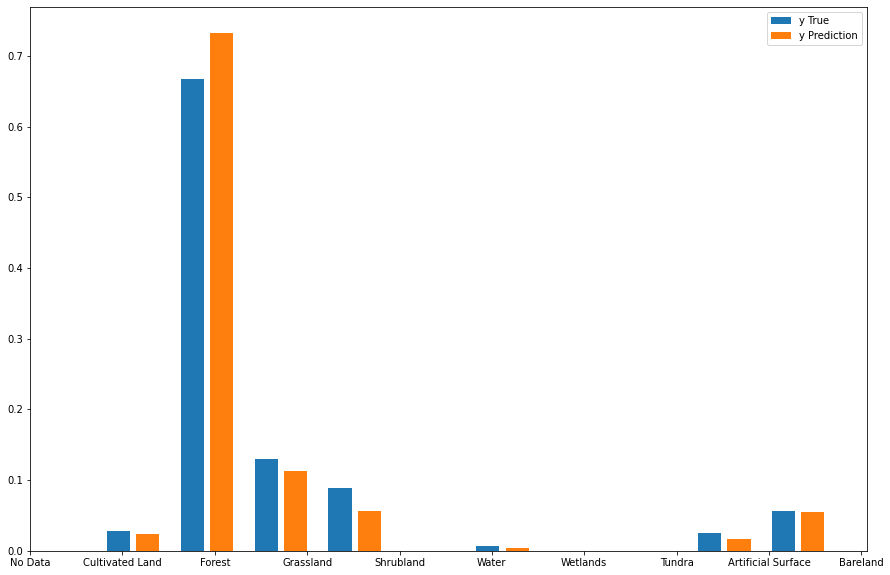

In [82]:
true = y_val
pred = cbm_predictions

plt.figure(figsize=[15, 10])
plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.hist(pred, color = 'y', width = 0.25, histtype='bar')
classes = ['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland']
plt.legend(['y True', 'y Prediction'])

plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

Extending the approach to surrounding pixels:


In [43]:
# create model
cbm_v2 = CatBoostClassifier(learning_rate=0.1, iterations=1000, random_seed=0, logging_level='Silent')

# fit model
cbm_v2.fit(X_train_v2, y_train_v2)

In [44]:
# Predict labels for test data
cbm_predictions_v2 = cbm_v2.predict(X_val_v2)

# Accuracy and Classification Report
print(f"Accuracy: {accuracy_score(y_val_v2, cbm_predictions_v2)*100}")
print(classification_report(y_val_v2, cbm_predictions_v2))

Accuracy: 84.21537045559134
              precision    recall  f1-score   support

           1       0.75      0.63      0.68        60
           2       0.89      0.98      0.93      1449
           3       0.73      0.66      0.69       281
           4       0.59      0.34      0.44       192
           5       1.00      0.53      0.70        15
           8       0.76      0.46      0.57        54
           9       0.73      0.75      0.74       122

    accuracy                           0.84      2173
   macro avg       0.78      0.62      0.68      2173
weighted avg       0.83      0.84      0.83      2173



## lightGBM:


In [47]:
d_train = lgb.Dataset(X_train, label=y_train)

# Parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=15
params['num_class']=11 #no.of unique values in the target class not inclusive of the end value

lgb_model = lgb.train(params, d_train, 100)


In [48]:
# prediction
lgb_predictions = lgb_model.predict(X_val)
lgb_pred = np.argmax(lgb_predictions, axis=1)

# Accuracy and Classification Report
print(f"Accuracy: {accuracy_score(y_val, lgb_pred)*100}")
print(classification_report(y_val, lgb_pred))

Accuracy: 82.83479061205706
              precision    recall  f1-score   support

           1       0.77      0.55      0.64        60
           2       0.87      0.98      0.92      1449
           3       0.70      0.63      0.66       281
           4       0.58      0.33      0.42       192
           5       1.00      0.40      0.57        15
           8       0.81      0.31      0.45        54
           9       0.77      0.73      0.75       122

    accuracy                           0.83      2173
   macro avg       0.78      0.56      0.63      2173
weighted avg       0.81      0.83      0.81      2173



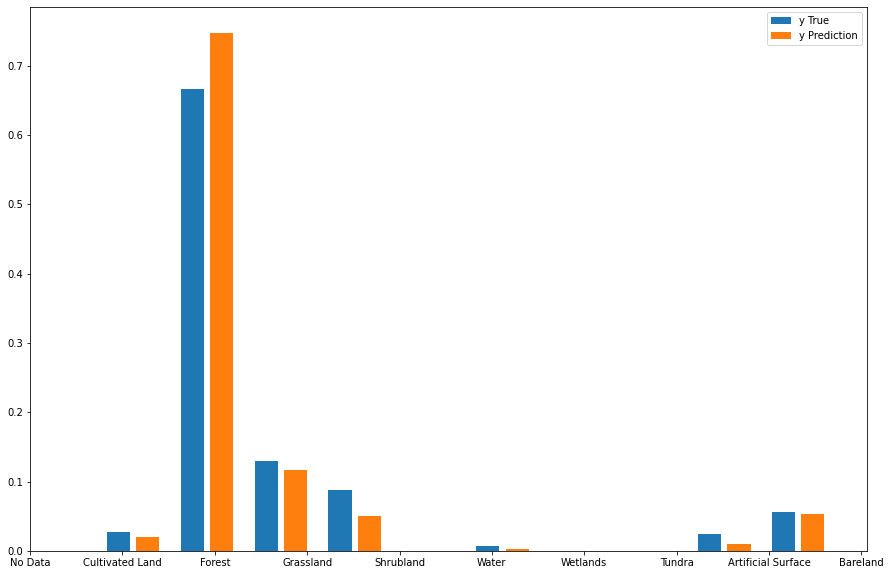

In [ ]:
true = y_val
pred = lgb_pred

plt.figure(figsize=[15, 10])
plt.hist([true, pred], width = 0.25, histtype='bar', weights=[(np.zeros_like(true) + 1. / true.size), (np.zeros_like(pred) + 1. / pred.size)], align='mid')
# plt.hist(pred, color = 'y', width = 0.25, histtype='bar')
classes = ['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland']
plt.legend(['y True', 'y Prediction'])

plt.xticks([i + 0.25 for i in range(len(classes))], classes)
plt.show()

Extending the approach to surrounding pixels:


In [49]:
d_train_v2 = lgb.Dataset(X_train_v2, label=y_train_v2)

# Parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=15
params['num_class']=11 #no.of unique values in the target class not inclusive of the end value

lgb_model_v2 = lgb.train(params, d_train_v2, 100)


In [50]:
# prediction
lgb_predictions_v2 = lgb_model_v2.predict(X_val_v2)
lgb_pred_v2 = np.argmax(lgb_predictions_v2, axis=1)

# Accuracy and Classification Report
print(f"Accuracy: {accuracy_score(y_val_v2, lgb_pred_v2)*100}")
print(classification_report(y_val_v2, lgb_pred))

Accuracy: 82.19052001840772
              precision    recall  f1-score   support

           1       0.77      0.55      0.64        60
           2       0.87      0.98      0.92      1449
           3       0.70      0.63      0.66       281
           4       0.58      0.33      0.42       192
           5       1.00      0.40      0.57        15
           8       0.81      0.31      0.45        54
           9       0.77      0.73      0.75       122

    accuracy                           0.83      2173
   macro avg       0.78      0.56      0.63      2173
weighted avg       0.81      0.83      0.81      2173



Grid search optimal parameters:

# Neural Network

Applying neural network to pixel average approach:

In [25]:
# one-hot-encode labels:
onehot = OneHotEncoder(sparse=False)
onehot.fit(y_train_v2.reshape((-1,1)))

X_train_v3 = X_train_v2
X_val_v3 = X_val_v2

y_train_v3 = onehot.transform(y_train_v2.reshape((-1,1)))
y_val_v3 = onehot.transform(y_val_v2.reshape((-1,1)))

In [26]:
# create model:
model = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(40, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(7, activation="softmax")
])

myoptimizer = keras.optimizers.Adam()
model.compile(loss="categorical_crossentropy", optimizer=myoptimizer, metrics=["accuracy"])

In [ ]:
# run on surrounding-pixel-train set
history = model.fit(X_train_v3, 
                    y_train_v3, 
                    epochs=200, 
                    validation_data=(X_val_v3, y_val_v3))

# 0.81 best score so far

In [66]:
# create model:
model2 = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(40, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation="softmax")
])

myoptimizer2 = keras.optimizers.Adam()
model2.compile(loss="categorical_crossentropy", optimizer=myoptimizer2, metrics=["accuracy"])

In [67]:
# run on only central pixel train set
history2 = model2.fit(X_train, 
                    y_train_v3, 
                    epochs=200, 
                    validation_data=(X_val, y_val_v3))

# 0.82 best score so far

Epoch 1/200
204/204 [==============================] - 1s 4ms/step - loss: 1.1819 - accuracy: 0.6572 - val_loss: 0.9149 - val_accuracy: 0.6949
Epoch 2/200
204/204 [==============================] - 1s 3ms/step - loss: 0.9456 - accuracy: 0.6897 - val_loss: 0.8546 - val_accuracy: 0.7013
Epoch 3/200
204/204 [==============================] - 1s 3ms/step - loss: 0.8571 - accuracy: 0.7147 - val_loss: 0.7488 - val_accuracy: 0.7520
Epoch 4/200
204/204 [==============================] - 1s 3ms/step - loss: 0.8281 - accuracy: 0.7325 - val_loss: 0.7393 - val_accuracy: 0.7584
Epoch 5/200
204/204 [==============================] - 1s 3ms/step - loss: 0.7706 - accuracy: 0.7503 - val_loss: 0.7332 - val_accuracy: 0.7524
Epoch 6/200
204/204 [==============================] - 1s 4ms/step - loss: 0.7363 - accuracy: 0.7602 - val_loss: 0.6571 - val_accuracy: 0.7805
Epoch 7/200
158/204 [======================>.......] - ETA: 0s - loss: 0.7285 - accuracy: 0.7625

KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame(history2.history)
df[['accuracy','val_accuracy']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

# Run on Testdataset

LightGBM:

In [ ]:
#Predict values
lgb_predictions_testset_probabilities = lgb_model.predict(X_test)
lgb_predictions_testset = np.argmax(lgb_predictions_testset_probabilities, axis=1)

In [ ]:
lgb_predictions_testset

array([1, 1, 1, ..., 2, 2, 2])

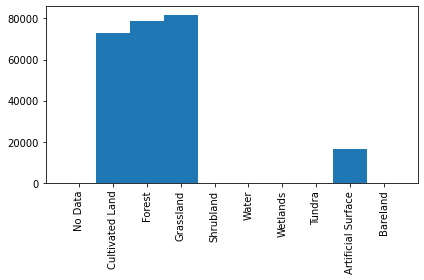

In [ ]:
##Plot predictions:
# Predicted class distribution:
plt.hist(lgb_predictions_testset, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Plot land-use-land-cover predictions:
# ep.plot_bands(lgb_predictions_testset, 
#              cmap=ListedColormap(['darkgreen', 'green', 'black', '#CA6F1E', 'navy', 'forestgreen', '#CA6F1E', '#CA6F1E', '#CA6F1E', '#CA6F1E', '#CA6F1E']))
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


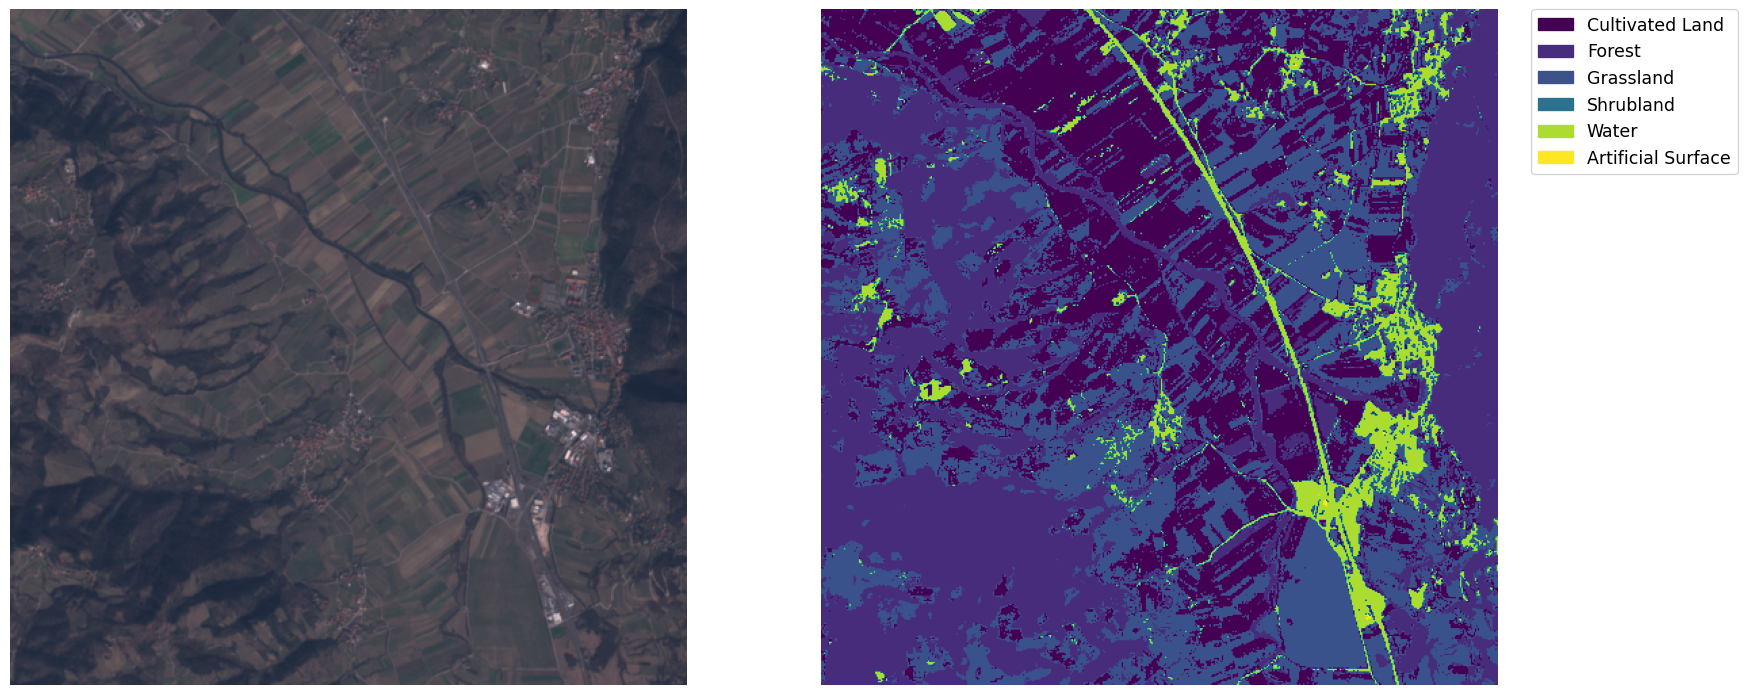

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), dpi=96)

# Plot correct image:
### Load September
band_sep = X_test_raw_shape[2,:,:,:3]
### Flip from BGR to RGB
band_flip = np.flip(band_sep, -1)
### Change Contrast
c_fact = 2.5
band = 0.5 + c_fact * (band_flip - 0.5)

ax1.axis('off')
ax1.imshow(band, cmap='gray')


# Plot prediction
im_arr = lgb_predictions_testset.reshape(500, 500)
bins = np.arange(10)
im_arr_bin = np.digitize(im_arr, bins)
cat_names = ['Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Artificial Surface']

im = ax2.imshow(im_arr_bin, cmap="gnuplot")
im_ax2 = ax2.imshow(im_arr_bin)
leg_neg = ep.draw_legend(im_ax = im_ax2, titles = cat_names)
ax2.axis('off')
plt.show()